In [1]:
!pip install transformers[torch] pandas scikit-learn seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [8]:
print("Loading model and its configuration...")
model_name = "Coolstew07/fine-tuned-roberta"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

label2id = model.config.label2id
id2label = model.config.id2label
label_names = list(id2label.values())

print(f"Model's true label map (from config): {label2id}\n")

Loading model and its configuration...
Model's true label map (from config): {'Anxiety': 0, 'Bipolar': 5, 'Depression': 2, 'Normal': 1, 'Personality disorder': 6, 'Stress': 4, 'Suicidal': 3}



In [9]:
print("Loading and preparing data...")
df = pd.read_csv('Combined Data.csv')
df.dropna(subset=['statement', 'status'], inplace=True)

df['status'] = df['status'].map(label2id)

df.dropna(subset=['status'], inplace=True)
df['status'] = df['status'].astype(int)

print("Splitting data...")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['statement'].tolist(), df['status'].tolist(),
    test_size=0.2,
    random_state=42
)

Loading and preparing data...
Splitting data...


In [10]:
print("Tokenizing validation set...")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

class StatusDataset(torch.utils.data.Dataset):
    """PyTorch dataset for feeding data to the model"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

val_dataset = StatusDataset(val_encodings, val_labels)

Tokenizing validation set...


In [11]:
print("Running predictions...")
# We only need the Trainer to run the .predict() function
trainer = Trainer(model=model)
predictions_output = trainer.predict(val_dataset)

# The output contains the logits, we need to find the highest logit (the prediction)
y_pred_logits = predictions_output.predictions
y_pred = np.argmax(y_pred_logits, axis=-1)
y_true = predictions_output.label_ids # These are the true labels

Running predictions...


In [12]:
accuracy = accuracy_score(y_true, y_pred)
print("\n" + "="*40)
print("--- Overall Model Accuracy (Corrected) ---")
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# **Classification Report**
# This shows precision, recall, and f1-score for each sentiment
print("--- Classification Report (Corrected) ---")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))
print("\n")


--- Overall Model Accuracy (Corrected) ---
Accuracy: 85.11%

--- Classification Report (Corrected) ---
                      precision    recall  f1-score   support

             Anxiety       0.89      0.90      0.90       755
              Normal       0.96      0.97      0.97      3308
          Depression       0.80      0.78      0.79      3016
            Suicidal       0.75      0.76      0.75      2158
              Stress       0.78      0.83      0.80       536
             Bipolar       0.88      0.91      0.89       527
Personality disorder       0.78      0.77      0.78       237

            accuracy                           0.85     10537
           macro avg       0.83      0.84      0.84     10537
        weighted avg       0.85      0.85      0.85     10537





--- Confusion Matrix (Corrected) ---


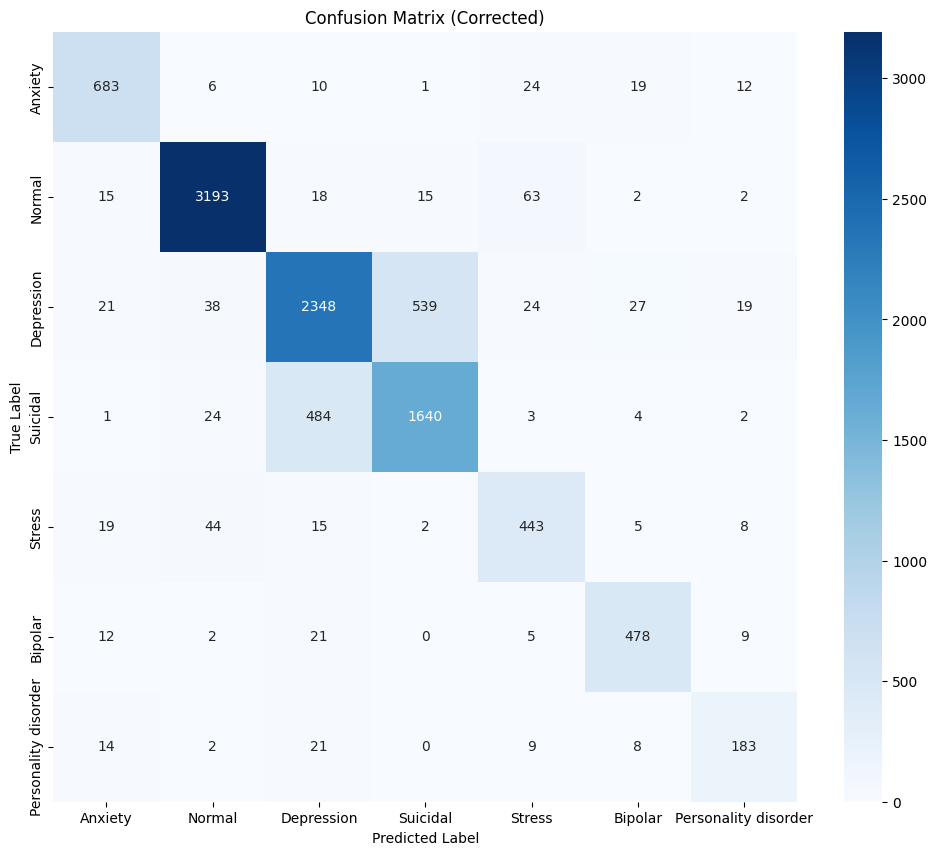

In [13]:
print("--- Confusion Matrix (Corrected) ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Confusion Matrix (Corrected)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()